# Wearable Stress and Affect Detection (WESAD) Exploratory Data Analysis

## Part 1: Chest Data Analysis

### [UCI Link](https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29#)

'''
Philip Schmidt, Attila Reiss, Robert Duerichen, Claus Marberger and Kristof Van Laerhoven. 2018. 
Introducing WESAD, a multimodal dataset for Wearable Stress and Affect Detection. 
In 2018 International Conference on Multimodal Interaction (ICMI '18), October 16-20, 2018, Boulder, CO, USA. ACM, New York, NY, USA, 9 pages.
'''

This dataset is part of the UCI ML Data repository and contains high granularity data (700 Hz) of 15 test subjects from chest worn sensors (RespiBAN) in the form of:
  - Electrocardiography (ECG)
  - Electrodermal Activity (EDA)
  - Electromyography (EMG)
  - Body Temp (Temp)
  - Accelorometer (ACC)
  - Respiration % (Resp)
  
Contains data at lower granularity from wrist worn (non dominant) Empatica device in the form of:
  - Accelorometer (ACC)
  - BVP
  - Electrodermal Activity (EDA)
  - Body Temp (Temp)

Wearable data generation has exploded in recent years, and with it the analysis of it. Time series data can yield very interesting insights and can paint a picture of people's health that they would not be able to see themselves.

Let's explore this data and see what we find. **This notebook will specifically look at chest data only (ECG, EDA, EMG, Body Temp, Accelermeter, Respiration %) with a part 2 for the wrist data due to the sheer amount of data being analyzed.**

## Quick Explanation of Chest Features (with linked sources)

 - [Electrocardiography (ECG)](https://biosignalsplux.com/downloads/docs/datasheets/Electrocardiography_(ECG)_Datasheet.pdf): "Electrocardiography (ECG) records electrical activity of the heart over time. Variations in the duration, amplitude, and morphology of the ECG waves are used for diagnosing abnormal cardiac rhythms and conduction patterns."

 - [Electrodermal Activity (EDA)](https://biosignalsplux.com/downloads/docs/datasheets/Electrodermal_Activity_(EDA)_Datasheet.pdf): "Electrodermal Activity (EDA) can be defined as a transient change in certain electrical properties of the skin, resulting from sweat secretion and sweat gland activity. These changes can result from elicited or natural stimuli that trigger a regulatory response by the sympathetic nervous system." 

 - [Electromyography (EMG)](https://biosignalsplux.com/downloads/docs/datasheets/Electromyography_(EMG)_Datasheet.pdf): "Muscle activation is triggered by bioelectrical signals of very low amplitude sent from motor control neurons on our brain to the muscle fibers. Electromyography (EMG) enables the translation of these electrical signals into numerical values, enabling them to be used in a wide array of applications."

 - [Body Temp (Temp)](https://biosignalsplux.com/downloads/docs/datasheets/Temperature_(TMP)_Datasheet.pdf): "Our high performance NTC sensors have been specifically developed for biomedical applications, and are meant to be used on a range of temperatures suitable for body sensing."

 - [Accelorometer (ACC)](https://biosignalsplux.com/downloads/docs/datasheets/Accelerometer_(ACC)_Datasheet.pdf): "...this sensor can measure sub-milliG accelerations and provides the raw magnitude data of each axis as an independent quantity giving you full control...this sensor can (also) be used to measure physical activity, range of motion, vibration, shocks, tilt, among many others."

 - [Respiration % (Resp)](https://biosignalsplux.com/downloads/docs/datasheets/Respiration_(PZT)_Datasheet.pdf): "(The sensor) has a localized sensing element that measures displacement variations induced by inhaling or exhaling. Typical applications include monitoring of respiratory rate, respiratory cycle regularity, relative amplitude of the cycle, and others."

## Import Packages and Configure Settings

In [1]:
# Do this first so we can have plots in the cells
%matplotlib inline
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import pickle

In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [4]:
# Choose ggplot
plt.style.use('ggplot')

# Before we start, let's fix the row/column displays so we can see all rows/columns
# Set ipython's max row display
pd.set_option('display.max_row', 100)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 100)

# Also for numpy, since we will be creating arrays off of the data
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

# Suppress scientific notation, show as decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Do this to have jupyter notebook displayed in FULL
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Preprocess & Clean Data

It's both exciting and exhausting to explore a data set without any context or guidance on how it should look/what issues may need to be accounted for. There's so many different possibilities that can be explored, but since no one has unlimited time on their hands one must always be diligent on how much time in spent in data cleaning + exploration.

Luckily for this dataset, the expected data format was already included with the data (and it is relatively easy to determine when exploring). I will still output some quick items for inspection like the df shape, columns and head. Let's go ahead and parse all the pickle files and create a subject dictionary of subject id-dataframe pairs.

In [43]:
# This is from the data_etl.py script
# Posting the format of the data below from the wesad_readme.pdf
"""
According to the README:
The double-tap signal pattern was used to manually synchronise the two devices' raw data. The result is provided in the files SX.pkl, one file per subject. This file is a dictionary, with the following keys:
- 'subject': SX, the subject ID
- 'signal': includes all the raw data, in two fields:
  - 'chest': RespiBAN data (all the modalities: ACC, ECG, EDA, EMG, RESP, TEMP)
  - 'wrist':EmpaticaE4data(all the modalities:ACC,BVP,EDA,TEMP)
- 'label': ID of the respective study protocol condition, sampled at 700 Hz. The following IDs
are provided: 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset
"""

# Study protocal conditions (label) mapping
label_map = {
    0: 'not defined / transient',
    1: 'baseline',
    2: 'stress',
    3: 'amusement',
    4: 'meditation',
}


# Read in WESAD datasets by subject and unpickle
subject_dct = {}
path = '../../data/WESAD'
filenames = glob.glob(os.path.join(path,'*/*.pkl'))
for file in filenames:
    
    # Had to use 'latin1' as the encoding due to Python 2/3 pickle incompatibility
    # https://stackoverflow.com/questions/11305790/pickle-incompatibility-of-numpy-arrays-between-python-2-and-3
    unpickled_file = pickle.load(open(file,'rb'), encoding='latin1')
    # Grab relevant info
    subject_id = unpickled_file['subject']
    print('processing subject',subject_id)
    # Grab chest and wrist dataframes
    chest_dct = unpickled_file['signal']['chest']
    wrist_dct = unpickled_file['signal']['wrist']

    # Process the chest dictionary first as it is more straight forward
    # Since the 'ACC' column contains 3 dimensional tuples, it needs to be processed separately due to pandas expecting the same format for all columns
    # Going to create dictionaries without that column to turn into a dataframe, then add the 'ACC' values later
    tmp_chest_dct = dict((k, chest_dct[k].ravel()) for k in list(chest_dct.keys()) if k not in ['ACC'])
    tmp_chest_df = pd.DataFrame(tmp_chest_dct) # Contains everything except ACC
    tmp_acc_df = pd.DataFrame(chest_dct['ACC'],columns=['ACC_X','ACC_Y','ACC_Z']) # Manually declare keys, otherwise shows up as 0,1,2
    final_chest_df = pd.concat([tmp_chest_df,tmp_acc_df],axis=1)

    # Process wrist dictionary, which will take more care because the samplying frequencies were different 
    # Meaning the number of data points collected for each feature is different (higher frequency equals more data points)
    # Basically this one just needs to be processed manually
    wrist_acc_df = pd.DataFrame(wrist_dct['ACC'],columns=['ACC_X','ACC_Y','ACC_Z'])
    wrist_bvp_df = pd.DataFrame(wrist_dct['BVP'],columns=['BVP'])
    wrist_eda_df = pd.DataFrame(wrist_dct['EDA'],columns=['EDA'])
    wrist_temp_df = pd.DataFrame(wrist_dct['TEMP'],columns=['TEMP'])

    # Add labels as a separate object to be returned
    # While the time granularity is the same as the chest data, I'm not sure yet how to use it with the wrist data
    # So will just keep it separate and add as needed
    labels_df = pd.DataFrame(unpickled_file['label'],columns=['label'])
    labels_df['mapped_label'] = labels_df['label'].map(label_map)
    labels_df['SUBJECT_ID'] = subject_id
    
    # Add subject id to all dataframes
    for df in [final_chest_df, wrist_acc_df, wrist_bvp_df, wrist_eda_df, wrist_temp_df]:
        df['SUBJECT_ID'] = subject_id

    subject_dct[subject_id] = {
        'chest_df': final_chest_df,
        'wrist_dfs': {
            'wrist_acc_df': wrist_acc_df,
            'wrist_bvp_df': wrist_bvp_df,
            'wrist_eda_df': wrist_eda_df,
            'wrist_temp_df': wrist_temp_df,
        },
        'labels': labels_df,
    }

../../data/WESAD/S5/S5.pkl
processing subject S5
Subject S5 took 4.157659292221069 seconds to load via pickle.
../../data/WESAD/S2/S2.pkl
processing subject S2
Subject S2 took 3.945188045501709 seconds to load via pickle.
../../data/WESAD/S3/S3.pkl
processing subject S3
Subject S3 took 4.216826915740967 seconds to load via pickle.
../../data/WESAD/S4/S4.pkl
processing subject S4
Subject S4 took 4.313539028167725 seconds to load via pickle.
../../data/WESAD/S17/S17.pkl
processing subject S17
Subject S17 took 3.7811760902404785 seconds to load via pickle.
../../data/WESAD/S10/S10.pkl
processing subject S10
Subject S10 took 3.5075700283050537 seconds to load via pickle.
../../data/WESAD/S11/S11.pkl
processing subject S11
Subject S11 took 3.315277099609375 seconds to load via pickle.
../../data/WESAD/S16/S16.pkl
processing subject S16
Subject S16 took 3.670977830886841 seconds to load via pickle.
../../data/WESAD/S8/S8.pkl
processing subject S8
Subject S8 took 3.6280698776245117 seconds to

# Quick Inspection of Data

Since we are working with wearables data it is reasonable to assume that the data we will be working with is largely continuous, with the labels being the one obvious discrete variable (which will require some additional analysis to inspect the distribution of that feature). 

For a randomly selected dataframe let's check out:
 - The shape of the data (number of rows and columns)
 - .The head (i.e. first n rows) of the dataset to get some example values
 - The different columns in the dataset
  
Later on we will plot out our data to see how it varies over time. Since this was an experiment I am predicting we will see spikes in certain measurements related to heart/respiratory rate during experiments designed to elicit emotional responses.

In [65]:
def quick_inspect(df):
    # Print out some quick items for our view
    print(df.shape)
    print(df.columns)
    display(df.head(10))

In [73]:
# Pick random subject to inspect
# According to the docs, Subject 1 and 12 had device malfunctions so their data was discarded
# So we will pick something between 2 and 17 and add logic to choose another number if 12 is chosen
removed_subjects = [12]
valid_choice = False
while not valid_choice:
    rand = randint(2,17)
    if rand not in removed_subjects:
        valid_choice = True
    else:
        print('Subject 12 chosen, choosing again')
rand_string = 'S' + str(rand)
print(rand_string)

S15


In [74]:
# Chest df
quick_inspect(subject_dct[rand_string]['chest_df'])

(3676400, 9)
Index(['ECG', 'EMG', 'EDA', 'Temp', 'Resp', 'ACC_X', 'ACC_Y', 'ACC_Z',
       'SUBJECT_ID'],
      dtype='object')


,ECG,EMG,EDA,Temp,Resp,ACC_X,ACC_Y,ACC_Z,SUBJECT_ID
0,-0.026,-0.016,1.362,33.493,0.691,0.830,0.312,1.147,S15
1,-0.013,-0.014,1.358,33.448,0.694,0.831,0.297,1.239,S15
2,0.003,-0.013,1.345,33.481,0.696,0.845,0.261,1.245,S15
3,0.008,-0.003,1.353,33.499,0.690,0.867,0.207,1.160,S15
4,0.007,-0.001,1.344,33.493,0.682,0.900,0.164,1.030,S15
5,0.003,0.012,1.345,33.493,0.690,0.916,0.090,0.921,S15
6,-0.006,0.015,1.362,33.493,0.685,0.847,-0.053,0.661,S15
7,-0.015,0.004,1.354,33.431,0.688,0.747,-0.165,0.328,S15
8,-0.024,0.010,1.360,33.496,0.697,0.749,-0.172,-0.056,S15
9,-0.037,0.009,1.347,33.430,0.661,0.840,-0.106,-0.413,S15


# Analyzing the Distributions of our Data

The built in describe() method in Pandas dataframes is a great way to get an initial idea of the distributions of the numeric features in your data. It outputs a standard 5 point summary (min, 25th percentile, median, 75th percentile, and max) as well as non-null data count, mean and standard deviation. We can use this to quickly determine things like: 
  - To what extent the data is skewed or not by comparing the mean to the median (or 50th percentile)
  - Looking at the other percentiles (25%, 75%) to get an idea of the extent the data is skewed in either direction

For this part I will combine all data and describe it in aggregate; we will lose information this way because we are removing the time series element as well as separation by subject. We will revisit this below.

Let's give it a go!

### Chest Monitor Data

We need to concatenate all data together to do this; its been a pain trying to do this due to all the data that's required to be joined.

Found this [article](https://towardsdatascience.com/speeding-up-pandas-dataframe-concatenation-748fe237244e) that describes how the pandas concatenate function is very costly and uses the index to do the join. By dropping the index the join becomes much faster.

Will demonstrate this below.

In [11]:
subject_ids = list(subject_dct.keys())
display(subject_ids)

['S5',
 'S2',
 'S3',
 'S4',
 'S17',
 'S10',
 'S11',
 'S16',
 'S8',
 'S6',
 'S7',
 'S9',
 'S13',
 'S14',
 'S15']

In [12]:
# First do without dropping index
import time

t0 = time.time()
'''
chest_data = []
label_data = []
for subject_id in subject_ids:
    chest_data.append(subject_dct[subject_id]['chest_df'])
    label_data.append(subject_dct[subject_id]['labels']['label'])
all_subjects_chest_data_df = pd.concat(chest_data)
all_subjects_labels_df = pd.concat(label_data)
all_subjects_chest_df = pd.concat([all_subjects_chest_data_df.reset_index(drop=True),all_subjects_labels_df.reset_index(drop=True)],axis=1)
'''

all_subjects_chest_data_df = pd.concat([subject_dct[subject_id]['chest_df'] for subject_id in list(subject_dct.keys())])
all_subjects_labels_df = pd.concat([subject_dct[subject_id]['labels']['label'] for subject_id in list(subject_dct.keys())])
all_subjects_chest_df = pd.concat([all_subjects_chest_data_df,all_subjects_labels_df],axis=1)

t1 = time.time()

total = t1-t0
print('Joining without dropping the index first took', total, 'seconds to complete.')

Joining without dropping the index first took 80.67178511619568 seconds to complete.


In [13]:
all_subjects_chest_df

,ECG,EMG,EDA,Temp,Resp,ACC_X,ACC_Y,ACC_Z,SUBJECT_ID,label
0,-0.276,0.017,3.888,34.120,0.044,0.861,0.074,0.857,S5,0
1,-0.230,0.015,3.913,34.143,0.032,0.846,0.078,0.857,S5,0
2,-0.195,0.015,3.873,34.135,0.015,0.841,0.087,0.757,S5,0
3,-0.164,-0.004,3.883,34.137,-0.063,0.842,0.099,0.578,S5,0
4,-0.135,0.018,3.887,34.118,0.017,0.855,0.098,0.333,S5,0
...,...,...,...,...,...,...,...,...,...,...
3676395,-0.166,0.005,4.121,34.421,-1.039,0.921,0.060,-0.186,S15,0
3676396,-0.163,-0.004,4.119,34.375,-1.065,0.921,0.062,-0.181,S15,0
3676397,-0.138,-0.011,4.120,34.335,-1.100,0.923,0.061,-0.178,S15,0
3676398,-0.112,-0.018,4.123,34.389,-1.106,0.922,0.063,-0.175,S15,0


In [14]:
# Now do the join with dropping the index before concatenating 
import time

t0 = time.time()
'''
chest_data = []
label_data = []
for subject_id in subject_ids:
    chest_data.append(subject_dct[subject_id]['chest_df'])
    label_data.append(subject_dct[subject_id]['labels']['label'])
all_subjects_chest_data_df = pd.concat(chest_data)
all_subjects_labels_df = pd.concat(label_data)
all_subjects_chest_df = pd.concat([all_subjects_chest_data_df.reset_index(drop=True),all_subjects_labels_df.reset_index(drop=True)],axis=1)
'''

all_subjects_chest_data_df = pd.concat([subject_dct[subject_id]['chest_df'] for subject_id in list(subject_dct.keys())])
all_subjects_labels_df = pd.concat([subject_dct[subject_id]['labels']['label'] for subject_id in list(subject_dct.keys())])
all_subjects_chest_df = pd.concat([all_subjects_chest_data_df.reset_index(drop=True),all_subjects_labels_df.reset_index(drop=True)],axis=1)

t1 = time.time()

total = t1-t0
print('Joining with dropping the first index took', total, 'seconds to complete.')

Joining with dropping the first index took 63.8558669090271 seconds to complete.


In [15]:
all_subjects_chest_df

,ECG,EMG,EDA,Temp,Resp,ACC_X,ACC_Y,ACC_Z,SUBJECT_ID,label
0,-0.276,0.017,3.888,34.120,0.044,0.861,0.074,0.857,S5,0
1,-0.230,0.015,3.913,34.143,0.032,0.846,0.078,0.857,S5,0
2,-0.195,0.015,3.873,34.135,0.015,0.841,0.087,0.757,S5,0
3,-0.164,-0.004,3.883,34.137,-0.063,0.842,0.099,0.578,S5,0
4,-0.135,0.018,3.887,34.118,0.017,0.855,0.098,0.333,S5,0
...,...,...,...,...,...,...,...,...,...,...
60807595,-0.166,0.005,4.121,34.421,-1.039,0.921,0.060,-0.186,S15,0
60807596,-0.163,-0.004,4.119,34.375,-1.065,0.921,0.062,-0.181,S15,0
60807597,-0.138,-0.011,4.120,34.335,-1.100,0.923,0.061,-0.178,S15,0
60807598,-0.112,-0.018,4.123,34.389,-1.106,0.922,0.063,-0.175,S15,0


In [16]:
# Describe data (drop label since summary statistics are meaningless for it) & suppress scientific notation
descriptive_stats = all_subjects_chest_df.drop(columns='label').describe().apply(lambda s: s.apply(lambda x: format(x, 'f'))) 
descriptive_stats

,ECG,EMG,EDA,Temp,Resp,ACC_X,ACC_Y,ACC_Z
count,60807600.000000,60807600.000000,60807600.000000,60807600.000000,60807600.000000,60807600.000000,60807600.000000,60807600.000000
mean,0.001065,-0.003038,4.888237,33.904938,0.054250,0.811687,-0.044248,-0.259008
std,0.268688,0.017905,3.531247,1.216936,4.099116,0.131253,0.103889,0.332166
min,-1.500000,-1.500000,0.000000,-273.149994,-50.000000,-6.600000,-6.600000,-6.600000
25%,-0.091690,-0.010208,2.328873,33.614044,-2.064514,0.759800,-0.079800,-0.465200
50%,-0.025955,-0.002701,3.719330,34.170288,-0.198364,0.862200,-0.031000,-0.252000
75%,0.033005,0.004257,7.057571,34.617126,2.171326,0.901000,0.015400,-0.067600
max,1.499954,1.464340,22.410965,35.778046,38.800049,2.981400,1.609000,4.508200


In [17]:
# Nice! Now can start getting an idea of what the numeric data looks like
# However, there are quite a bit of statistics here
# Let's first look at the mean, medians and percentiles
descriptive_stats.loc[['mean','std','25%','50%','75%']]

,ECG,EMG,EDA,Temp,Resp,ACC_X,ACC_Y,ACC_Z
mean,0.001065,-0.003038,4.888237,33.904938,0.054250,0.811687,-0.044248,-0.259008
std,0.268688,0.017905,3.531247,1.216936,4.099116,0.131253,0.103889,0.332166
25%,-0.091690,-0.010208,2.328873,33.614044,-2.064514,0.759800,-0.079800,-0.465200
50%,-0.025955,-0.002701,3.719330,34.170288,-0.198364,0.862200,-0.031000,-0.252000
75%,0.033005,0.004257,7.057571,34.617126,2.171326,0.901000,0.015400,-0.067600


# A Closer Look

## Histograms
If we really want to see how the values of a given feature are spread out and concentrated, we should plot the counts of each unique data point in each feature set.

To do this pythonically (and to cut down on unnecessary code), we will define functions that will get unique value counts of a feature passed as an input, and then use those counts and plot a quick and dirty histogram.

This way we can separately get a list of counts and analyze it by itself, as well as not have to create a ton of variables storing unique value counts of various features.

**Note: This is a great starting point to analyze numerical categorical data (i.e. labels)**

**Another note: We are ignoring the time element here, so any observations here should be taken with a grain of salt**

In [21]:
'''
# Reposting study protocal conditions (label) mapping for reference
label_map = {
    0: 'not defined / transient',
    1: 'baseline',
    2: 'stress',
    3: 'amusement',
    4: 'meditation',
}
'''

array([[<AxesSubplot:title={'center':'ECG'}>,
        <AxesSubplot:title={'center':'EMG'}>,
        <AxesSubplot:title={'center':'EDA'}>],
       [<AxesSubplot:title={'center':'Temp'}>,
        <AxesSubplot:title={'center':'Resp'}>,
        <AxesSubplot:title={'center':'ACC_X'}>],
       [<AxesSubplot:title={'center':'ACC_Y'}>,
        <AxesSubplot:title={'center':'ACC_Z'}>,
        <AxesSubplot:title={'center':'label'}>]], dtype=object)

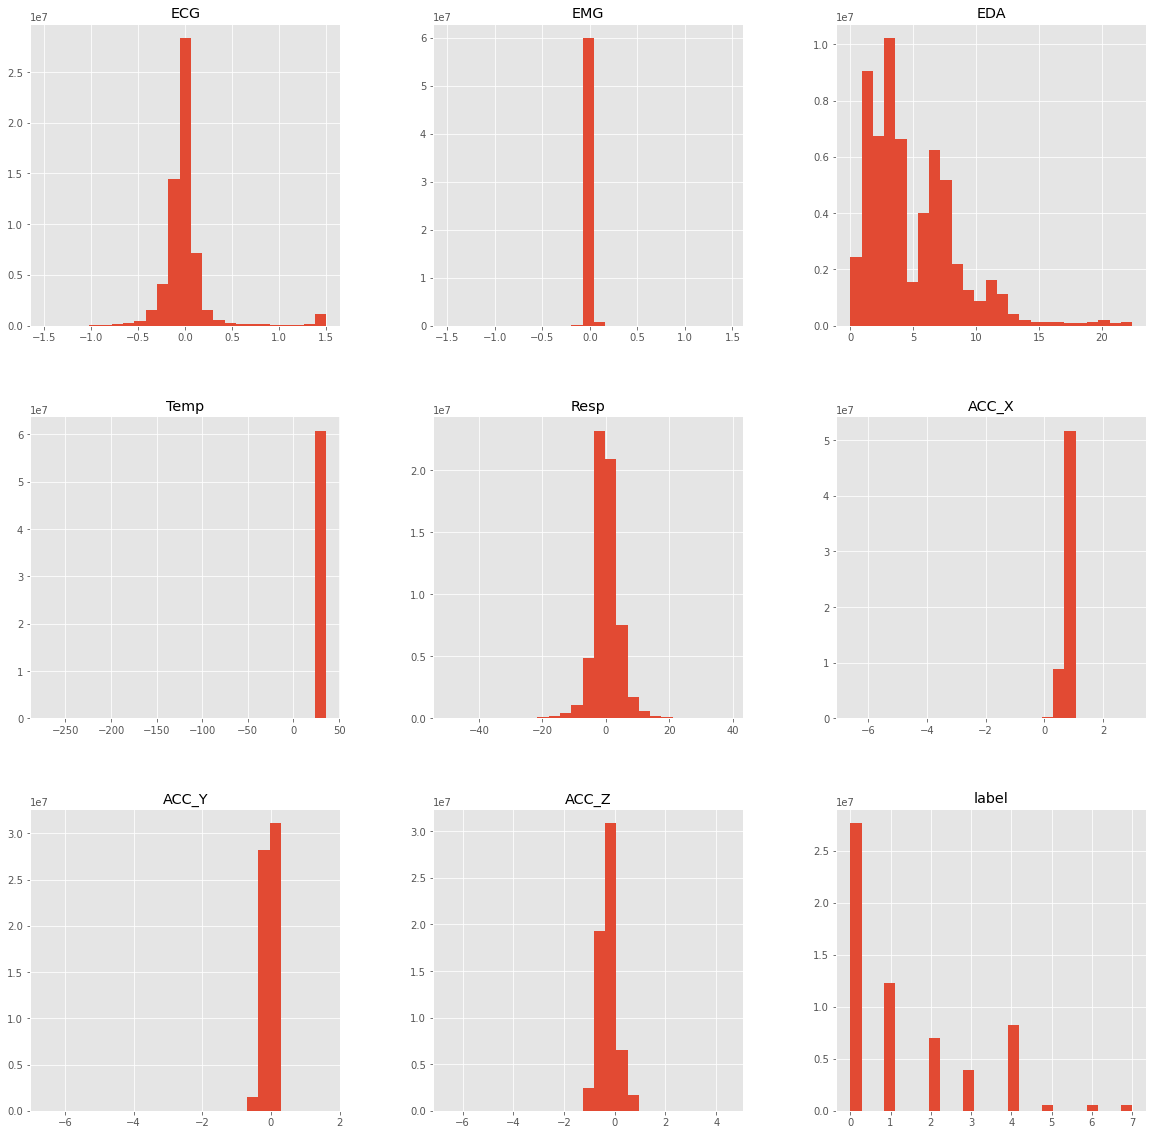

In [83]:
all_subjects_chest_df.hist(figsize=(20,20),bins=25)

# Some Observations on the Sensor Data

- Electrocardiography (ECG): 
  - Nothing too much here, low average values, standard deviation and interquartile range. 
  - This is a measure of heart rate variability, so this suggests that for the most part there was no abormal electrical activity in the heart (we'll look into this more later)
  - **This should be validated by a corresponding low variance in the respitory rate data since heart rate and breathing rate are highly linked**
- Electromyography (EMG): 
  - Nothing much here at all: low average values, standard deviation and interquartile range
- Electrodermal Activity (EDA): 
  - EDA is defined as "transient change in certain electrical properties of the skin, resulting from sweat secretion and sweat gland activity"
  - Here we start to see more variation in the data from the other sensors, although it appears that the data fit between 1 and 10. 
  - This is likely due to the intended exercises in the experiment designed to elicit emotional reponses from the subjects. 
    - There was probably one experiment that was designed to elicit a huge response, while the others were for moderate responses
- Accelerometer (ACC): 
  - Can't tell too much from just the descriptive statistics
    - There was hardly any variation in the data points (low standard deviation and inter quartile range), so the minimum and maximum values were likely outliers. 
  - This should make sense too because this sensor is on the chest so it therefore won't move too much in any one direction unless the participants were all over the place.
- Body Temperature (Celsius):
  - Like the first set of sensors, the variation here is very low and there isn't too much to conclude other than the body temperature of the participants did not seem to vary that much (~33-34 degrees Celsius)
    - The minimum value of -273 does suggest an error in data collection (_or someone's heart is just that cold??_) since this corresponds to absolute zero and the range of acceptable values was 0 - 50 according to the linked datasheets in the paper
- Respitory %: 
  - Healthy amount of variation here; still largely normally distributed  w/ relatively low standard deviation and interquartile range
      - **For the most part validates the observations around heart rate data above**
  - There were likely experiments designed to elicit emotional responses, so the values at the tails likely represent this
- Labels:
  - Order of class by decreasing frequency as follows  (5,6, and 7 should be ignored):
    1. 'not defined/transient'
    2. 'baseline'
    3. 'meditation'
    4. 'stress', 
    5. 'amusement'
  - This is mostly as expected, but looks like the state of meditation is quite frequent so that is worth a closer look
  

# Some of my overall assumptions based on what's we've seen so far

Based on the above observations let's make a couple assumptions about the data and use other methods to try and prove them wrong:
1. Most of the high respitory rate data occurred during a specific range of values (i.e. during a specific stress experiment).
2. Higher EDA values correlate highly (?) to labels of 'stress' and 'amusement' (and lower correspond to 'meditation' and 'baseline').
3. Most of the changes to the accelerometer data occur during a specific range of values (moving to different areas for experiments)
4. The EDA wrist and EDA chest data are highly correlated per subject (all above 0.5)

# Now let's prove them wrong!!

## Plot Data Directly

In order to get the complete picture and test out the above assumptions, we should plot the data in order to see how it varies across the time period of the experiment. In order to be able to compare each subjects's data in the most intuitive way we will plot all subject data onto one graph. This will allow us to validate or discard some of the early conclusions made above.

**Note: We can do this because we have a limited number of actual subjects in the data; if there were hundreds it wouldn't be practical to graph each subject's data on one graph (instead it would be more appropriate to graph summary statistics)**

## Chest Data + Labels

We're going to have to plot these one by one due to the sheer amount of data for each category. Even the plots below take around half a minute each just to render properly...

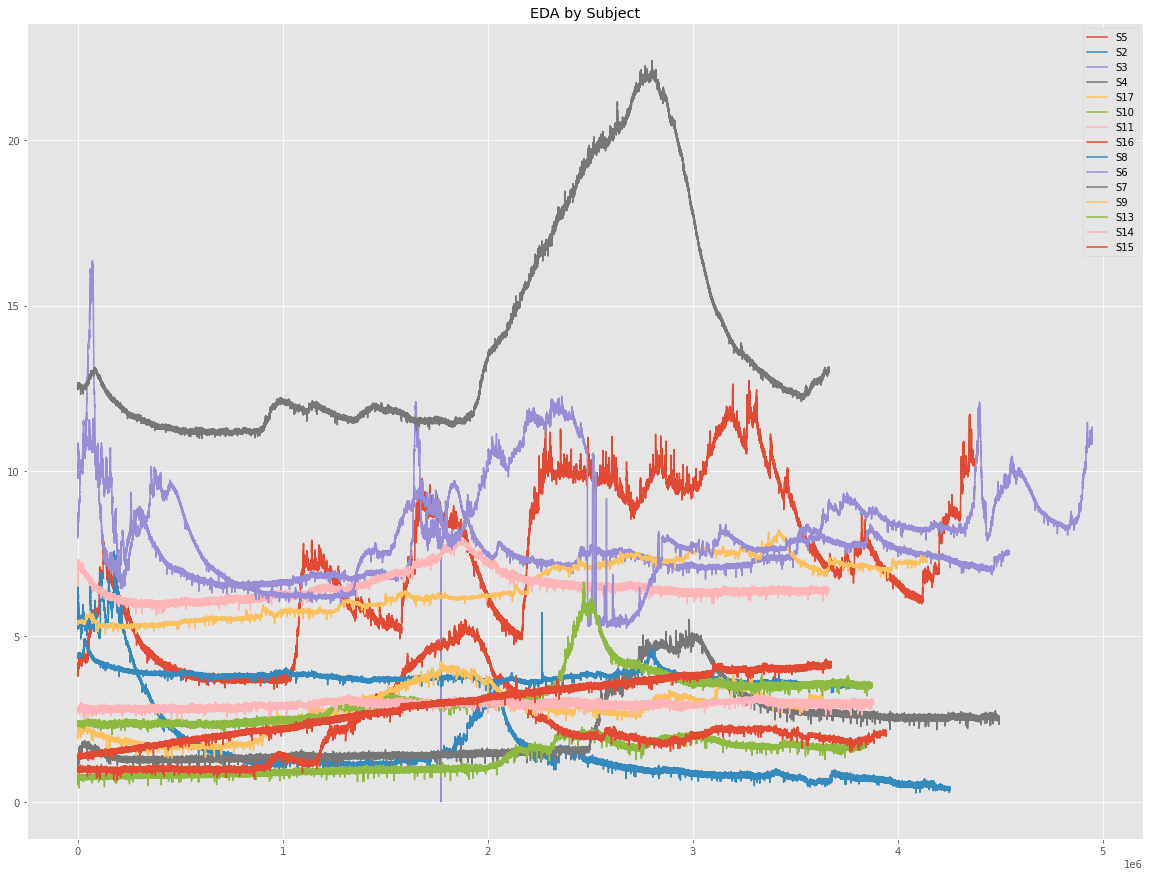

In [24]:
fig, ax = plt.subplots()

for subject in subject_ids:
    subject_dct[subject]['chest_df']['EDA'].plot(figsize = (20,15), label = subject)

ax.legend(subject_ids)
ax.set_title('EDA by Subject')
plt.show()

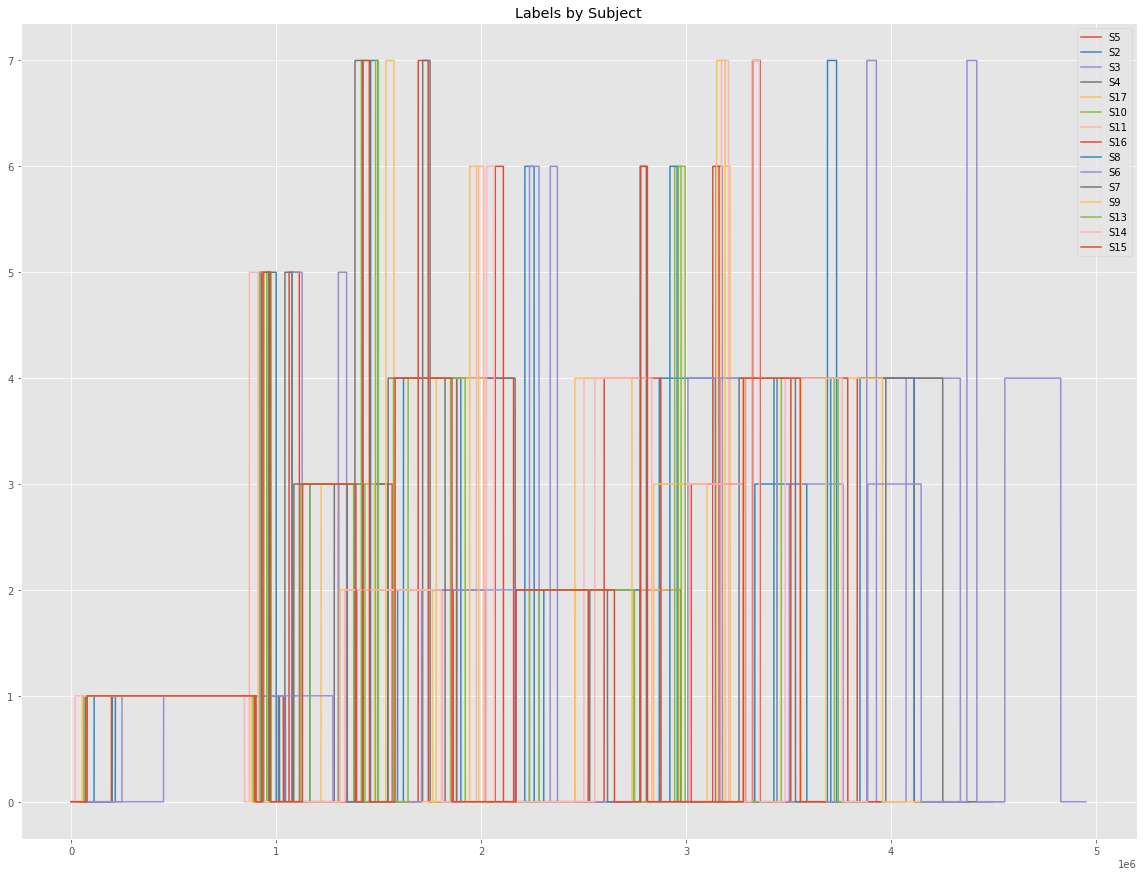

In [25]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['labels']['label'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('Labels by Subject')
plt.show()

In [ ]:
fig, ax = plt.subplots()
for subject in subject_ids:
    
    subject_dct[subject]['chest_df']['ECG'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('ECG by Subject')
plt.show()

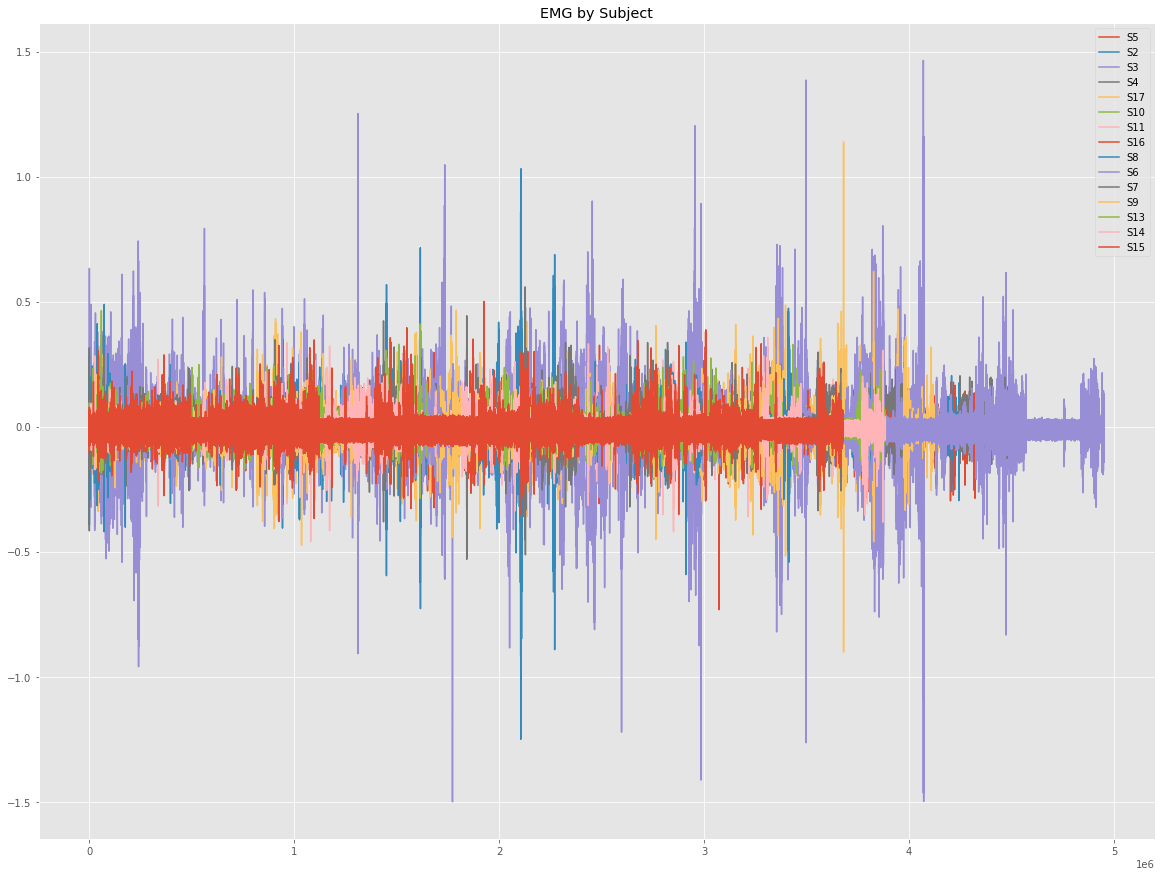

In [27]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['chest_df']['EMG'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('EMG by Subject')
plt.show()

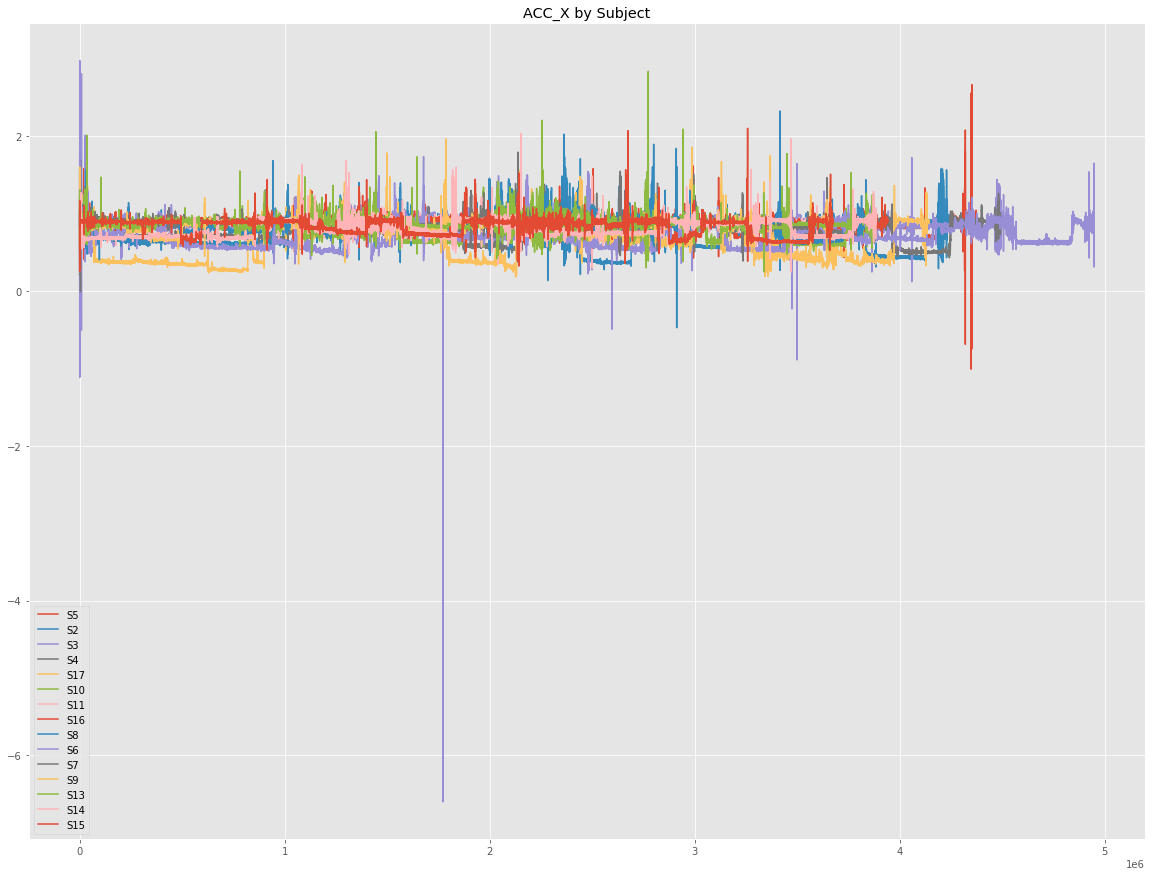

In [28]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['chest_df']['ACC_X'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('ACC_X by Subject')
plt.show()

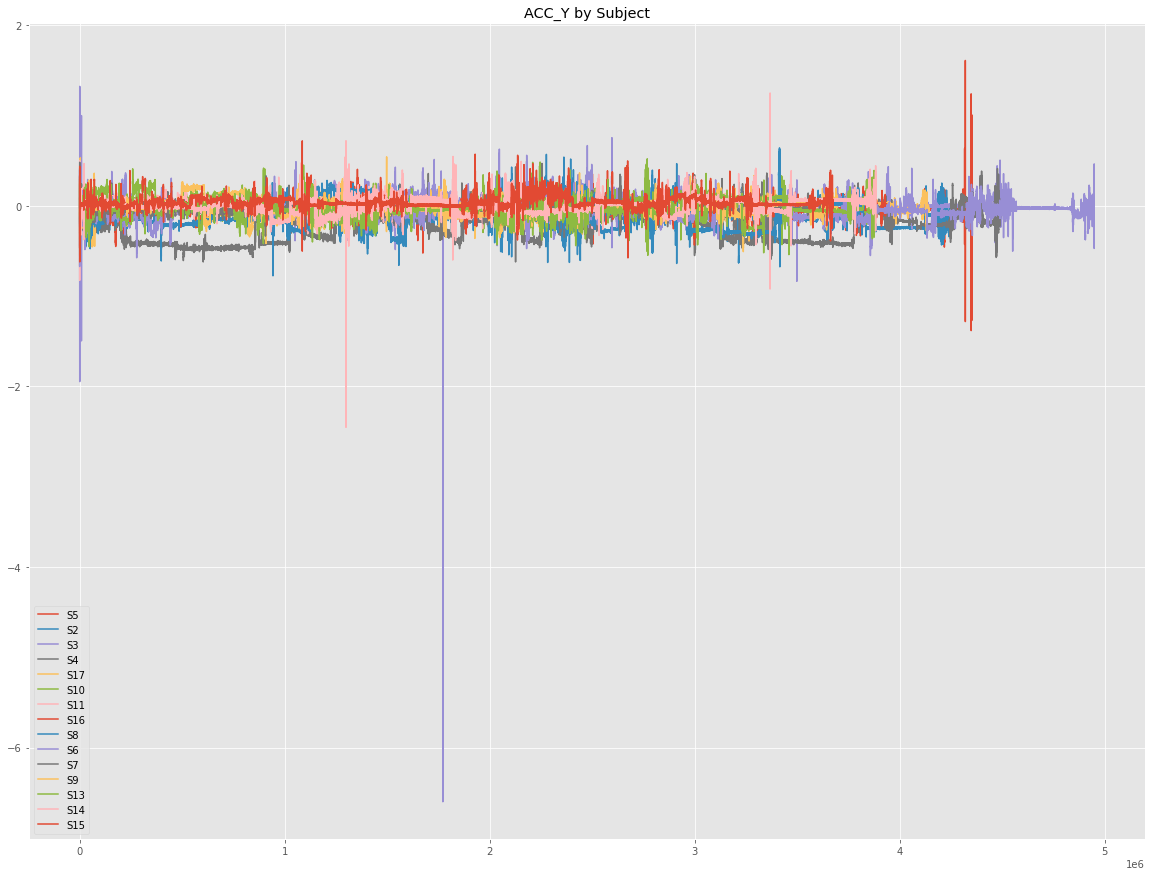

In [29]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['chest_df']['ACC_Y'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('ACC_Y by Subject')
plt.show()

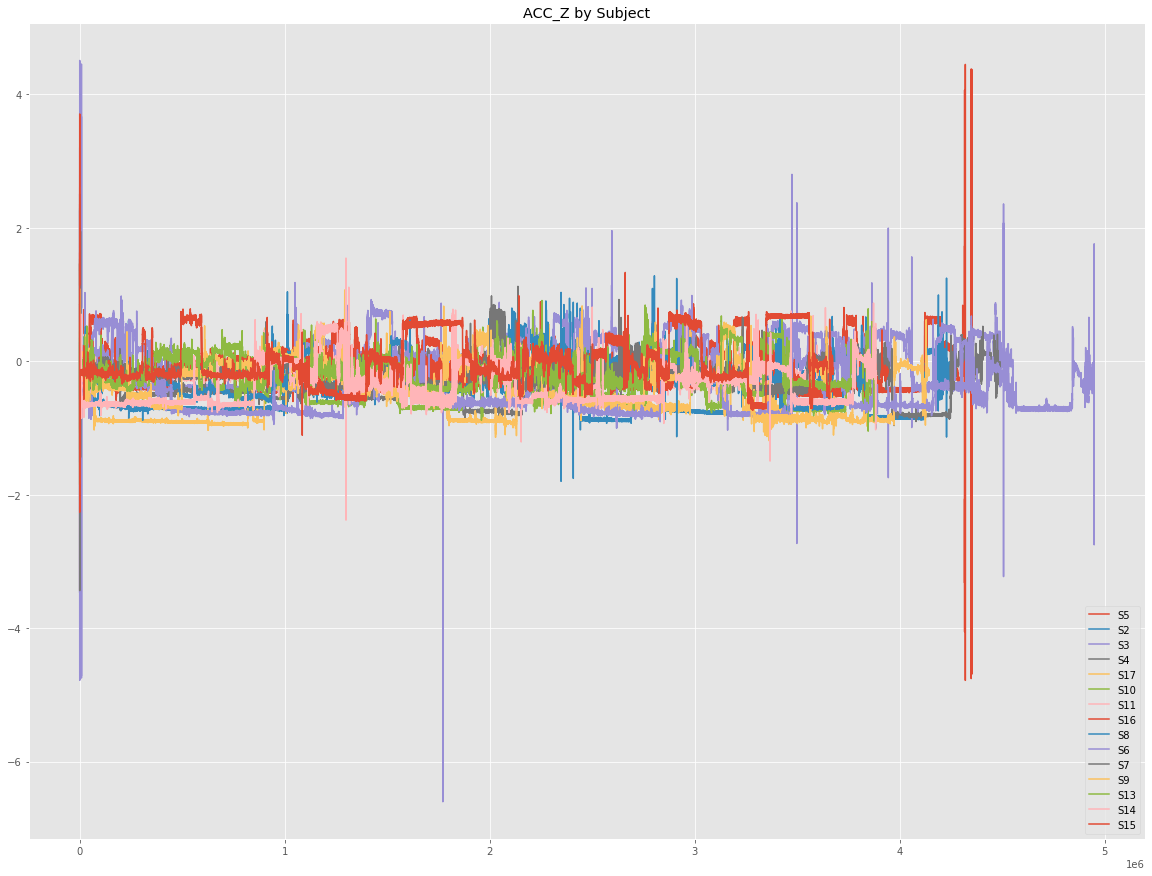

In [30]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['chest_df']['ACC_Z'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('ACC_Z by Subject')
plt.show()

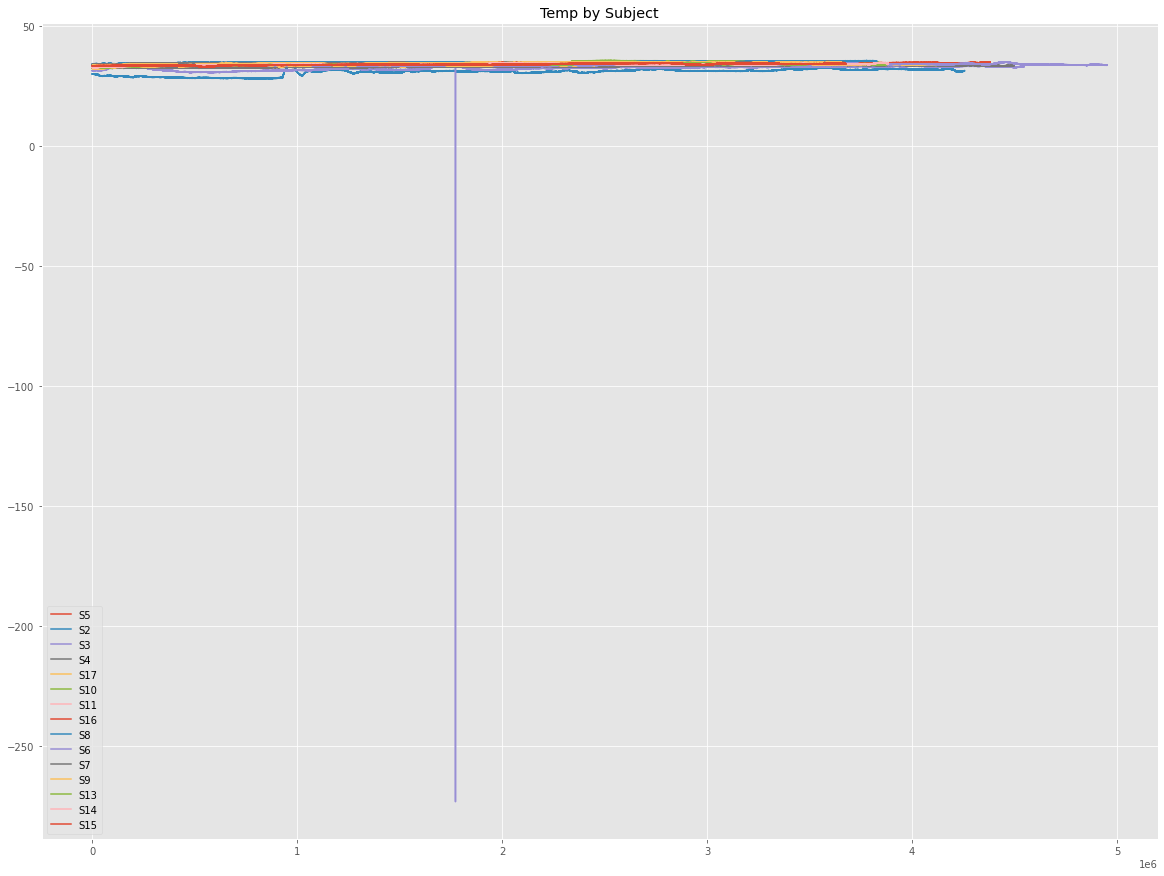

In [31]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['chest_df']['Temp'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('Temp by Subject')
plt.show()

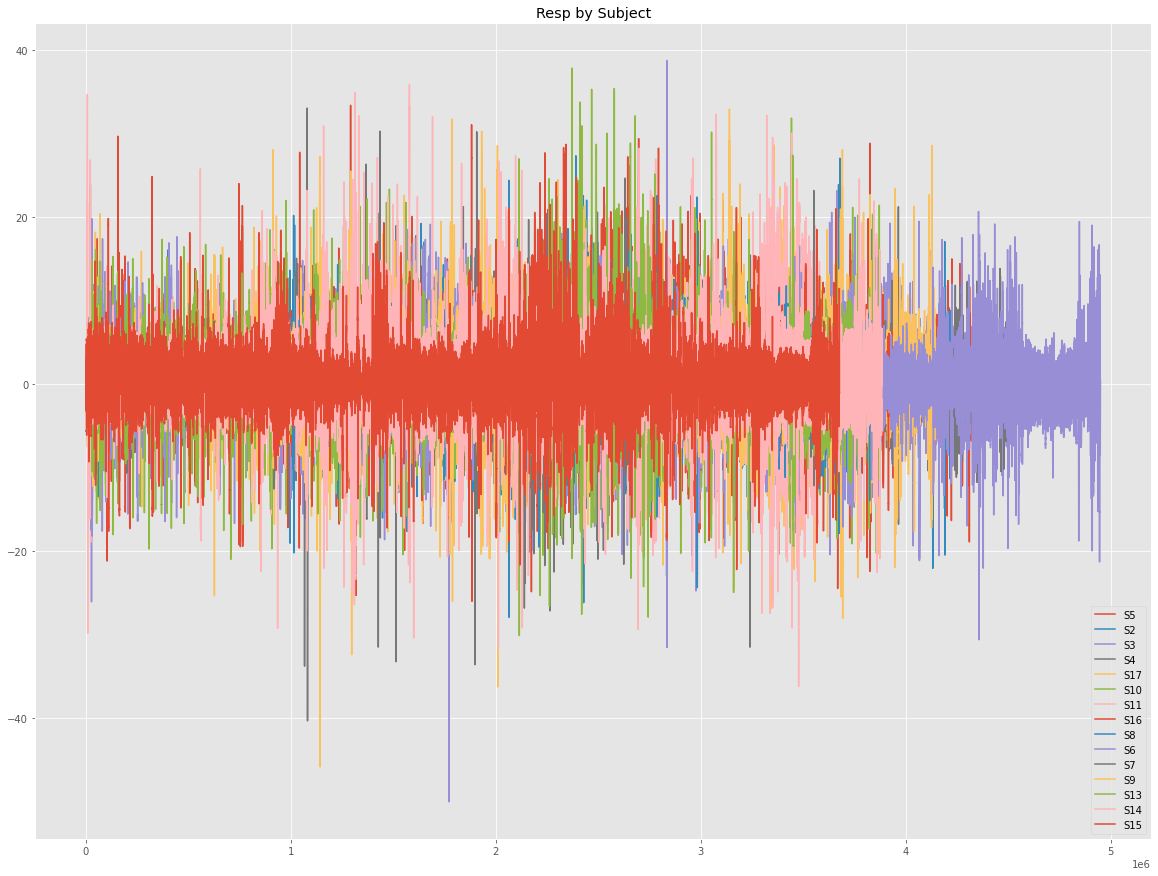

In [32]:
fig, ax = plt.subplots()
for subject in subject_ids:
    subject_dct[subject]['chest_df']['Resp'].plot(figsize = (20,15))

ax.legend(subject_ids)
ax.set_title('Resp by Subject')
plt.show()

# Scatter Plots

While the above descriptive statistics are helpful, it may be less clear how features with similar measures (mean, median, standard deviation, etc.) relate to each other (if at all). We should graph these features against each other and see how they relate to each other (negatively/positively, strong/weak, etc.). 

If we end up deciding to try and create a model later, this analysis will help us decide what variables to use and remove.

For this, we will import another visualization packages (seaborn) that has some nicer plotting features and functionalities.

## Chest Data

In [34]:
# Import package and plot correlation
import seaborn as sns

chest_corr = all_subjects_chest_df.corr()
display(chest_corr)

,ECG,EMG,EDA,Temp,Resp,ACC_X,ACC_Y,ACC_Z,label
ECG,1.000,-0.104,-0.000,0.002,0.007,-0.001,0.001,-0.001,0.000
EMG,-0.104,1.000,-0.005,0.024,0.001,0.014,-0.003,0.005,-0.002
EDA,-0.000,-0.005,1.000,0.197,-0.000,0.061,0.136,0.101,-0.024
Temp,0.002,0.024,0.197,1.000,0.004,0.180,0.235,0.096,0.085
Resp,0.007,0.001,-0.000,0.004,1.000,-0.002,-0.003,0.002,0.000
ACC_X,-0.001,0.014,0.061,0.180,-0.002,1.000,0.108,0.625,-0.193
ACC_Y,0.001,-0.003,0.136,0.235,-0.003,0.108,1.000,0.084,0.112
ACC_Z,-0.001,0.005,0.101,0.096,0.002,0.625,0.084,1.000,-0.247
label,0.000,-0.002,-0.024,0.085,0.000,-0.193,0.112,-0.247,1.000


Looks like there isn't much strong correlation here, let's graph it for a better view

In [59]:
# Still alot of variables, but let's give it a go and see what happens
# From https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
def plot_sns_heatmap(corr):
    plt.figure(figsize=(14,14))
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(220, 20, n=200),
        square=True,
        annot=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

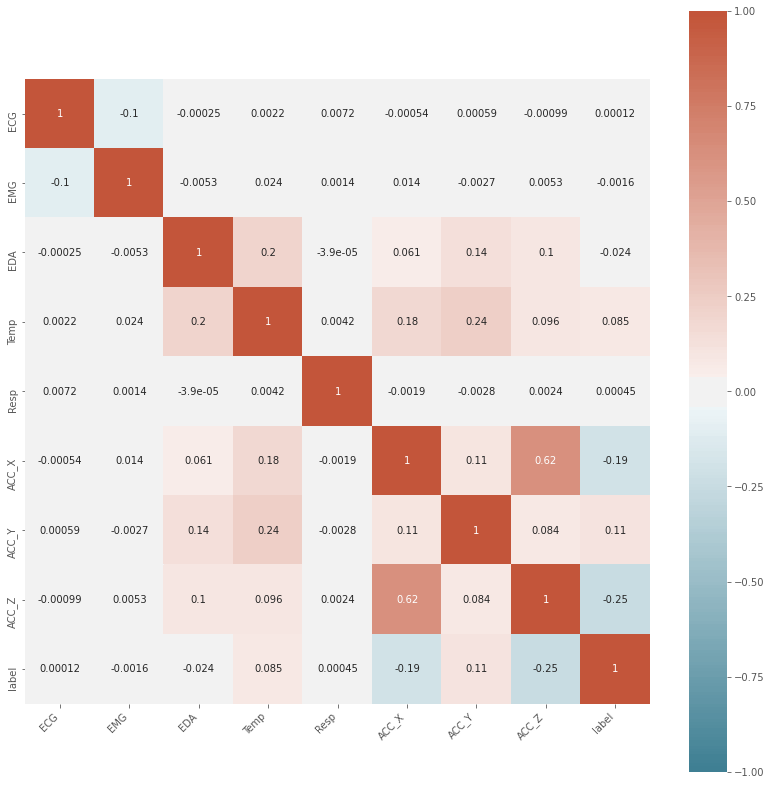

In [60]:
plot_sns_heatmap(chest_corr)

# Conclusions

TO BE FILLED IN